## Gene similarity

In [2]:
import os

#retrieves gene from a file in FASTA format
def readGene(filename):
    with open(filename, 'r') as f:
        data = f.read()
    return data[data.find('\n'):].replace('\n','')
    
    
#runs the GenCompress algorithm on the given gene and returns the size of the output
def compressGene(gene,condition):
    with open('tmp','w') as tmp:
        tmp.write(gene)
        if condition:
            with open('tmp_cond','w') as tmp_cond:
                tmp_cond.write(condition)
                os.system('./GenCompress tmp -c tmp_cond')
        else:
            os.system('./GenCompress tmp')
    size = os.stat('./tmp.GEN').st_size
    os.remove('./tmp')
    os.remove('./tmp.GEN')
    os.remove('./tmp.LOG')
    if condition:
        os.remove('./tmp_cond')
    return size

#returns similarity(distance) of the given genes
def geneSimilarity(uFile,vFile):
    u = readGene(uFile)
    v = readGene(vFile)
    cu = compressGene(u,None)
    cuv = compressGene(u+v,None)
    cu_v = compressGene(u,v)
    return 1 - 1.0*(cu - cu_v)/cu_v

## Similarity matrix

In [3]:
import numpy as np
import sys

filenames = []

def getNumber(filename):
    name = filename[filename.rfind(os.path.sep)+1:]
    return int(name[:name.find('.')])

for root, _, files in os.walk('genes'):      
    for filename in files:
        if(filename.endswith('.fasta')):
            filenames.append(os.path.join(root,filename))
            
size = len(filenames)
print('Found '+str(size)+' species')
simMatrix = np.zeros((size,size))

total = int(size*size-size)
done = 0

for i in range(0,size):
    for j in range(0,size):
        if i != j:
            uFile = filenames[i];
            vFile = filenames[j];
            uIndex = getNumber(uFile)-1
            vIndex = getNumber(vFile)-1
            simMatrix[uIndex,vIndex] = geneSimilarity(uFile,vFile)
            simMatrix[vIndex,uIndex] = simMatrix[uIndex,vIndex]
            done += 1
            sys.stdout.write("\rCalculating similarity {}/{}".format(done,total))
            sys.stdout.flush()
print('\nDone')

Found 29 species
Calculating similarity 812/812
Done


## Nearest neighbours

In [5]:
from tabulate import tabulate

simTmp = simMatrix.copy()
for i in range(0,size):
    simTmp[i,i]=1

nn = np.argmin(simTmp,0)

with open('species','r') as speciesFile:
    species = speciesFile.read().split('\n')[:-1]

width = max([len(s) for s in species]) + 1

nnPairs = [(species[i],species[nn[i]]) for i in range(0,size)]

print(tabulate(nnPairs,headers=['Species','Nearest neighbour'],tablefmt="fancy_grid"))


╒═══════════════════╤═════════════════════╕
│ Species           │ Nearest neighbour   │
╞═══════════════════╪═════════════════════╡
│ baboon            │ common chimpanzee   │
├───────────────────┼─────────────────────┤
│ cat               │ harbor seal         │
├───────────────────┼─────────────────────┤
│ common chimpanzee │ bonobo chimpanzee   │
├───────────────────┼─────────────────────┤
│ bonobo chimpanzee │ common chimpanzee   │
├───────────────────┼─────────────────────┤
│ cow               │ sheep               │
├───────────────────┼─────────────────────┤
│ dog               │ gray seal           │
├───────────────────┼─────────────────────┤
│ donkey            │ horse               │
├───────────────────┼─────────────────────┤
│ fat dormouse      │ squirrel            │
├───────────────────┼─────────────────────┤
│ gibbon            │ common chimpanzee   │
├───────────────────┼─────────────────────┤
│ gorilla           │ common chimpanzee   │
├───────────────────┼───────────

## Download and resize images

In [6]:
import os
import shutil # used for 'rm -r'
import sys
import json
from io import StringIO
from PIL import Image
from urllib.request import FancyURLopener
import requests

imagesDir = './images/'
tmpDir = "./tmp915667/"
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)
if not os.path.exists(imagesDir):
    os.makedirs(imagesDir)

with open('species','r') as speciesFile:
    species = speciesFile.read().split('\n')[:-1]

def getImageUrl(keyword):
    searchTerm = keyword
    startIndex = "0"
    searchUrl = "http://ajax.googleapis.com/ajax/services/search/images?v=1.0&q=" + searchTerm + "&start=" + startIndex
    
    jsonFile = requests.get(searchUrl).json()
    imageUrl = jsonFile['responseData']['results'][0]['unescapedUrl']
    return imageUrl

# Http header must be changed because some websites don't allow downloading image to robots
class MyOpener(FancyURLopener):
    version = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; it; rv:1.8.1.11) Gecko/20071127 Firefox/2.0.0.11'

def downloadImage(imageUrl, searchTerm):
    myopener = MyOpener()
    tmpImagePath = tmpDir + searchTerm
    myopener.retrieve(imageUrl, tmpImagePath)
    return tmpImagePath

total = len(species)
current = 1
for searchTerm in species:
    sys.stdout.write("\rDownloading image of " + searchTerm + " ... " + "{}/{}\n".format(current,total))
    sys.stdout.flush()
    imageUrl = getImageUrl(searchTerm)
    tmpImagePath = downloadImage(imageUrl, searchTerm)
    resImagePath = imagesDir + searchTerm + ".png"
    Image.open(tmpImagePath).resize((300, 200), Image.BILINEAR).save(resImagePath)
    current += 1

shutil.rmtree(tmpDir)
print("Done")


Done


/usr/lib64/python3.4/site-packages/ipykernel/__main__.py:34: DeprecationWarning: MyOpener style of invoking requests is deprecated. Use newer urlopen functions/methods


In [64]:
#import networkx as nx
from pygraphviz import AGraph
#import string

distMatrix = 15 * simMatrix * np.array(simMatrix >= 0, dtype=int)

#dt = [('len', float)]
#G = nx.from_numpy_matrix(distMatrix.view(dt))

# Generate a graph description for graphviz, adding one node at a time
G = AGraph(fontsize=100)
for y in range(size):
    G.add_node(y, image="{}{}.png".format(imagesDir, species[y]), xlabel=species[y], shape="rectange", fontsize=50)
    for x in range(y+1, size):
        G.add_edge(y, x, len=distMatrix[y, x])
        
#G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), string.ascii_uppercase)))
#G = nx.to_agraph(G)

#G.node_attr.update(style="filled")
#G.edge_attr.update(color="blue", width="2.0")

# Create graph image
with open("grafx.dot", "w") as fout:
    print(G, file=fout) 
os.system("neato -Tpng -o grafx.png grafx.dot")

#G.draw(path='graf5.png', prog='neato')

0

![graf](grafx.png)

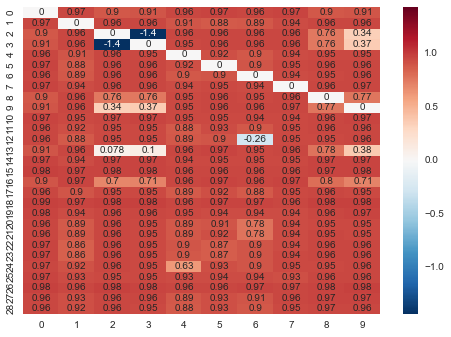

In [79]:
import seaborn as sns
%matplotlib inline
sns.set()

sns.heatmap(simMatrix[:, 0:10], annot=True)
